# Tutorial: Semi-analytic calculation of neutrino leakage

## Author: Leo Werneck
### Special thanks to Ariadna Murguia-Berthier for sharing the code in which this tutorial notebook was based on.

In this tutorial notebook we study how a [neutrino leakage scheme](http://adsabs.harvard.edu/pdf/1996A%26A...311..532R) affects the evolution of [hydrodynamics](https://en.wikipedia.org/wiki/Fluid_dynamics) quantities in a simplified scenario. We assume an [isotropic gas](https://en.wikipedia.org/wiki/Kinetic_theory_of_gases) of constant density, temperature, and electron fraction in [flat spacetime](https://en.wikipedia.org/wiki/Minkowski_space) with no magnetic fields. In this case, the general relativistic [magnetohydrodynamics](https://en.wikipedia.org/wiki/Magnetohydrodynamics) (GRMHD) equations reduce to (cf. Eqs. 59 and 60 of [Murguia-Berthier *et al.*](https://arxiv.org/pdf/2106.05356.pdf))

$$
\newcommand{\me}{m_{\rm e}}
\newcommand{\nb}{n_{\rm b}}
\newcommand{\ee}{e^{-}}
\newcommand{\ae}{e^{+}}
\newcommand{\nue}{\nu_{\rm e}}
\newcommand{\anue}{\bar{\nu}_{\rm e}}
\newcommand{\nui}{\nu_{\rm i}}
\newcommand{\anui}{\bar{\nu}_{\rm i}}
\newcommand{\nux}{\nu_{\rm x}}
\newcommand{\anux}{\bar{\nu}_{\rm x}}
\newcommand{\rhob}{\rho_{\rm b}}
\newcommand{\ye}{Y_{\rm e}}
\newcommand{\QQ}{\mathcal{Q}}
\newcommand{\RR}{\mathcal{R}}
\begin{aligned}
\partial_{t}T^{t}_{\ \ t} &= \QQ,\\
\partial_{t}\ye &= \RR/\rhob,
\end{aligned}
$$

where $\rhob$ is the baryonic density, $\ye$ is the electron fraction, and $T^{\mu}_{\ \ \nu}$ is the energy-momentum of the gas. The source terms $\QQ$ and $\RR$ correspond to the energy loss and the emission/absorption rates due to [neutrinos and anti-neutrinos](https://en.wikipedia.org/wiki/Neutrino) of the reactions of the [$\beta$-processes](https://en.wikipedia.org/wiki/Beta_decay).

<a id='initialize_nrpy'></a>

# Step 1: Load necessary Python/NRPy+ modules \[Back to [Top](#toc)\]
$$\label{initialize_nrpy}$$

In [1]:
# Step 1: Load necessary Python/NRPy+ modules
import numpy as np
import astropy.constants as ct
import astropy.units as units
import fdint

# Step 1.a: Set useful physical constants
h         = ct.h.cgs.to("MeV s").value # MeV s
c         = ct.c.cgs.value             # cm / s
m_e_c2    = ct.m_e.cgs * ct.c.cgs**2
m_e_c2    = m_e_c2.to("MeV").value     # MeV
hc3       = (h*c)**3                   # MeV^3 cm^3
sigma_0   = 1.76e-44                   # cm^{-2}
N_A       = ct.N_A.cgs.value           # 1/mol
gamma_0   = 5.565e-2
alpha     = 1.23                       # https://arxiv.org/abs/1306.4953
Q_npmass  = 1.2935                     # https://arxiv.org/abs/1306.4953
alpha_f   = ct.alpha.value             # Fine-structure constant
Cv        = 0.5 + 2.0*0.23 # Vector coupling
Ca        = 0.5            # Axial coupling
CvCa_aux1 = ((Cv-Ca)**2 + (Cv+Ca)**2)/36.0
CvCa_aux2 = ((Cv-Ca)**2 + (Cv+Ca-2)**2)/9.0
Br_const  = 2.0778e2 * units.erg.to('MeV')
f_Br      = 0.5

# Step 1.b: Compute beta (Eq. A6 of https://arxiv.org/abs/1306.4953)
beta = np.pi * c *(1+3*alpha**2)*sigma_0/(hc3*m_e_c2**2)

<a id='numerical_implementation'></a>

# Step 2: Numerical implementation \[Back to [Top](#toc)\]
$$\label{numerical_implementation}$$

We now provide the numerical implementation of the source terms $\RR$ and $\QQ$.

<a id='electron_capture'></a>

## Step 2.a: Electron capture: computing $\RR_{\rm ec}$ and $\QQ_{\rm ec}$ \[Back to [Top](#toc)\]
$$\label{electron_capture}$$

We now compute the neutrino emission and cooling rates for the electron capture (ec) by a proton, $\RR_{\rm ec}$ and $\QQ_{\rm ec}$, respectively, which arise from the reaction

$$
\ee + p \to n + \nue,
$$

where $\ee$, $p$, $n$, and $\nue$ are the electron, proton, neutron, and electron neutrino, respectively. The rates are given by Eqs. (A5) and (A6) of [Galleazi *et al.* (2013)](https://arxiv.org/abs/1306.4953),

$$
\begin{align}
\RR_{\rm ec}(\nue) &= \beta\eta_{\rm np}T^{5}F_{4}(\eta_{\rm e})\left[1-f_{\nue}\right]_{\rm ec},\\
\QQ_{\rm ec}(\nue) &= \beta\eta_{\rm np}T^{6}F_{5}(\eta_{\rm e})\left[1-f_{\nue}\right]_{\rm ec},
\end{align}
$$

where $\rhob$ is the baryonic density, $T$ is the temperature, and $F_{n}$ are Fermi-Dirac integrals,

$$
F_{n}(\eta) = \int_{0}^{\infty}\frac{x^{n}dx}{e^{x-\eta}+1}.
$$

Moreover, we have

$$
\beta = \frac{\pi}{h^{3}c^{2}}\frac{1+3\alpha^{2}}{\me^{2} c^{4}}\sigma_{0},
$$

where $h$ is the [Planck constant](https://en.wikipedia.org/wiki/Planck_constant), $c$ is the [speed of light](https://en.wikipedia.org/wiki/Speed_of_light), $\me$ is the electron mass, $\sigma_{0} \approx 1.705 \times 10^{-44}\ {\rm cm^{2}}$ ([Ruffert *et al.* (1996)](http://adsabs.harvard.edu/pdf/1996A%26A...311..532R) use $\sigma_{0} \approx 1.76 \times 10^{-44}\ {\rm cm^{2}}$), the weak axial-vector coupling constant is $\alpha\approx1.23$ ([Ruffert *et al.* (1996)](http://adsabs.harvard.edu/pdf/1996A%26A...311..532R) use $\alpha\approx1.25$), $\eta_{i}\equiv\mu_{i}/T$ are the degeneracy parameters for different particle species, and

$$
\eta_{\rm np} = \frac{n_{\rm n}-n_{\rm p}}{e^{\hat\eta}-1} = N_{A}\rhob\left(\frac{X_{\rm n}-X_{\rm p}}{e^{\hat\eta}-1}\right),
$$

is the Pauli blocking factor, where $n_{\rm n}$ and $n_{\rm p}$ are the neutron and proton number densities, respectively, and $\hat\eta=\eta_{\rm n}-\eta_{\rm p} - Q/T$ is the difference between neutron and proton relativistic degeneracy parameters, with $Q = 1.2935\ {\rm MeV}$ the [rest-mass-energy](https://en.wikipedia.org/wiki/Mass_in_special_relativity) difference between a neutron and a proton. For densities smaller than $1\times10^{11}\ {\rm g\,cm^{-3}}$, we use $n_{\rm np}\approx n_{\rm p} = N_{A}\rhob X_{\rm p}$ instead. Temperatures are given in MeV.

We also use the approximate expression (cf. Eqs. A9 of [Galleazi *et al.* (2013)](https://arxiv.org/abs/1306.4953))

$$
\begin{align}
\left[1-f_{\nue}\right]_{\rm ec} \approx \left\{1 + \exp\left[-\frac{F_{5}(\eta_{\rm e})}{F_{4}(\eta_{\rm e})}-\eta_{\nue}\right]\right\}^{-1},
\end{align}
$$

where

$$
\eta_{\nue} = -\eta_{\anue} = \eta_{\rm e} + \eta_{\rm p} - \eta_{\rm n}.
$$

We also compute the neutrino emission and cooling rates for the positron capture (pc) by a neutron, $\RR_{\rm pc}$ and $\QQ_{\rm pc}$, respectively, which arise from the reaction

$$
\ae + n \to p + \anue,
$$

where $\ae$ and $\anue$ are the positron and the electron antineutrino, respectively. The rates are given by Eqs. (A2) and (A3) of [Galleazi *et al.* (2013)](https://arxiv.org/abs/1306.4953),

$$
\begin{align}
\RR_{\rm pc}(\anue) &= \beta\,\eta_{\rm pn}T^{5}F_{4}(-\eta_{\rm e})\left[1-f_{\anue}\right]_{\rm pc},\\
\QQ_{\rm pc}(\anue) &= \beta\,\eta_{\rm pn}T^{6}F_{5}(-\eta_{\rm e})\left[1-f_{\anue}\right]_{\rm pc},
\end{align}
$$

where

$$
\left[1-f_{\anue}\right]_{\rm pc} \approx \left\{1 + \exp\left[-\frac{F_{5}(-\eta_{\rm e})}{F_{4}(-\eta_{\rm e})}-\eta_{\anue}\right]\right\}^{-1},
$$

and

$$
\eta_{\rm pn} = \frac{n_{\rm p}-n_{\rm n}}{e^{-\hat\eta}-1} = N_{A}\rhob\left(\frac{X_{\rm p}-X_{\rm n}}{e^{-\hat\eta}-1}\right).
$$

For densities smaller than $1\times10^{11}\ {\rm g\,cm^{-3}}$ we use $\eta_{\rm pn}\approx n_{\rm n} = N_{A}\rhob X_{\rm n}$.

In [2]:
# Step 2.a: Neutrino emission & cooling rates (electron capture)
def neutrino_emission_and_cooling_rates_beta_processes(rho_b,Ye,T,mu_e,mu_p,mu_n,X_n,X_p):

    # Step 2.a.i: Compute degeneracy parameters
    eta_e    = mu_e/T
    eta_p    = mu_p/T
    eta_n    = mu_n/T
    eta_nue  = eta_e + eta_p - eta_n
    eta_anue = -eta_nue
    eta_hat  = eta_n - eta_p - Q_npmass/T

    # Step 2.a.ii: Compute Pauli blocking factor
    if rho_b >= 1e11:
        eta_np = N_A * rho_b * (X_n - X_p) / (np.exp(eta_hat)-1)
        eta_pn = N_A * rho_b * (X_p - X_n) / (np.exp(-eta_hat)-1)
    else:
        eta_np = N_A * rho_b * X_p
        eta_pn = N_A * rho_b * X_n

    # Step 2.a.iii: Compute Fermi-Dirac integrals
    F_5_peta_e = fdint.fdk(5,eta_e)
    F_4_peta_e = fdint.fdk(4,eta_e)
    F_5_meta_e = fdint.fdk(5,-eta_e)
    F_4_meta_e = fdint.fdk(4,-eta_e)

    # Step 2.a.iv: Compute blocking factor for electron & positron capture
    blocking_factor_ec = 1/(1 + np.exp(-F_5_peta_e/F_4_peta_e-eta_nue))
    blocking_factor_pc = 1/(1 + np.exp(-F_5_meta_e/F_4_meta_e-eta_anue))
    
    # Step 2.a.v: Compute emission and cooling rates
    # Eqs. B1, B2, B14, and B15 in https://adsabs.harvard.edu/pdf/1996A%26A...311..532R
    tmp         = beta * T**5
    tmp_ec      = tmp * eta_np * blocking_factor_ec
    tmp_pc      = tmp * eta_pn * blocking_factor_pc
    R_beta_nue  = tmp_ec * F_4_peta_e
    Q_beta_nue  = tmp_ec * F_5_peta_e * T
    R_beta_anue = tmp_pc * F_4_meta_e
    Q_beta_anue = tmp_pc * F_5_meta_e * T
    R_beta_nux  = 0.0
    Q_beta_nux  = 0.0

    return R_beta_nue,Q_beta_nue, R_beta_anue,Q_beta_anue, R_beta_nux,Q_beta_nux

<a id='pair_annihilation'></a>

## Step 2.b: Pair annihilation: computing $\RR_{\ae\ee}$ and $\QQ_{\ae\ee}$ \[Back to [Top](#toc)\]
$$\label{pair_annihilation}$$

We now compute the neutrino emission and cooling rates for the positron capture (pc) by a neutron, $\RR_{\rm pc}$ and $\QQ_{\rm pc}$, respectively, which arise from the reaction

$$
\ae + \ee \to \nui + \anui,
$$

where $\nui = (\nue,\nux)$, where $x$ represents both the muon and the tau.

Consider electron-positron pair annihilation leading to the production of an electron neutrino-antineutrino pair,

$$
\ae + \ee \to \nue + \anue.
$$

The neutrino emission rate for this process is given by (cf. Eq. A13 of [Galleazi *et al.* (2013)](https://arxiv.org/abs/1306.4953))

$$
\RR_{\ae\ee}(\nue,\anue) = \frac{(C_{1}+C_{2})_{\nue\anue}}{36\nb}\frac{\sigma_{0}c}{\me^{2}c^{4}}
\epsilon_{4}(\ae)\epsilon_{4}(\ee)\left[1-f_{\nue}(\eta_{\rm e},\eta_{\nue})\right]_{\ae\ee}\left[1-f_{\anue}(\eta_{\rm e},\eta_{\anue})\right]_{\ae\ee},
$$

where

$$
(C_{1}+C_{2})_{\nue\anue} = \left(C_{V}-C_{A}\right)^{2} + \left(C_{V}+C_{A}\right)^{2},
$$

with $C_{V}=0.962$ and $C_{A} = 0.5$. $\epsilon_{N}$ are energy moments of the Fermi-Dirac distribution for massive particles, given by (cf. Eq. A15 of [Galleazi *et al.* (2013)](https://arxiv.org/abs/1306.4953))

$$
\epsilon_{N}\bigl(e^{\mp}\bigr) = \frac{8\pi}{(hc)^{3}}T^{N}F_{N-1}\bigl(\pm\eta_{\rm e}\bigr).
$$

For the process involving heavy neutrinos, i.e.,

$$
\ae + \ee \to \nux + \anux,
$$

the emission rate is given by

$$
\RR_{\ae\ee}(\nux,\anux) = \frac{(C_{1}+C_{2})_{\nux\anux}}{9\nb}\frac{\sigma_{0}c}{\me^{2}c^{4}}
\epsilon_{4}(\ae)\epsilon_{4}(\ee)\left[1-f_{\anux}(\eta_{\rm e},\eta_{\nux})\right]_{\ae\ee},
$$

where $(C_{1}+C_{2})_{\nux\anux} = (C_{V}-C_{A})^{2} + (C_{V}+C_{A}-2)^{2}$ and (cf. Eq. A17 of [Galleazi *et al.* (2013)](https://arxiv.org/abs/1306.4953))

$$
\left[1-f_{\nui}(\eta_{\rm e},\eta_{\nui})\right]_{\ae\ee} \approx \left\{1+\exp\left[-\frac{1}{2}\left(\frac{F_{3}(\eta_{\rm e})}{F_{4}(\eta_{\rm e})} + \frac{F_{3}(-\eta_{\rm e})}{F_{4}(-\eta_{\rm e})}\right)+\eta_{i}\right]\right\}^{-1}.
$$

The heating/cooling rate is given by (cf. Eq. A18 of [Galleazi *et al.* (2013)](https://arxiv.org/abs/1306.4953))

$$
\QQ_{\ae\ee}(\nui,\anui) = \RR_{\ae\ee}(\nui,\anui)\frac{1}{2}\frac{\epsilon_{5}(\ee)\epsilon_{4}(\ae) + \epsilon_{4}(\ee)\epsilon_{5}(\ae)}{\epsilon_{4}(\ee)\epsilon_{4}(\ae)}.
$$

In [3]:
# Step 2.b: Neutrino emission & cooling rates (pair annihilation)
def neutrino_emission_and_cooling_rates_pair_annihilation(rho_b,Ye,T,mu_e,mu_p,mu_n):
    
    # Step 2.b.i: Compute degeneracy parameters
    eta_e    = mu_e/T
    eta_p    = mu_p/T
    eta_n    = mu_n/T
    eta_nue  = eta_e + eta_p - eta_n
    eta_anue = -eta_nue
    eta_nux  = 0.0

    # Step 2.b.ii: Compute Fermi-Dirac integrals
    F_3_peta_e = fdint.fdk(3,+eta_e)
    F_4_peta_e = fdint.fdk(4,+eta_e)
    F_3_meta_e = fdint.fdk(3,-eta_e)
    F_4_meta_e = fdint.fdk(4,-eta_e)

    # Step 2.b.iii: Compute auxiliary quantities
    Fermi_factor = 0.5*(F_3_peta_e/(F_4_peta_e+1e-20) + F_3_meta_e/(F_4_meta_e+1e-20))

    # Step 2.b.iv: Compute blocking factors for pair annihilation
    blocking_factor_nue  = 1/(1+np.exp(eta_nue  - Fermi_factor))
    blocking_factor_anue = 1/(1+np.exp(eta_anue - Fermi_factor))
    blocking_factor_nux  = 1/(1+np.exp(eta_nux  - Fermi_factor))

    # Step 2.b.v: Compute energy moments
    common_factor  = 8 * np.pi * T**4 / hc3
    eps_4_electron = common_factor * F_3_peta_e
    eps_5_electron = common_factor * F_4_peta_e * T
    eps_4_positron = common_factor * F_3_meta_e
    eps_5_positron = common_factor * F_4_meta_e * T

    # Step 2.b.vi: Compute emission rates
    # Eqs. B8 & B10 in https://adsabs.harvard.edu/pdf/1996A%26A...311..532R
    common_factor = sigma_0 * c * eps_4_electron * eps_4_positron / (m_e_c2)**2
    R_pair_nue    = CvCa_aux1 * common_factor * blocking_factor_nue * blocking_factor_anue
    R_pair_anue   = R_pair_nue
    R_pair_nux    = CvCa_aux2 * common_factor * blocking_factor_nux * blocking_factor_nux

    # Step 2.b.vii: Compute cooling rates
    # Eq. B16 in https://adsabs.harvard.edu/pdf/1996A%26A...311..532R
    common_factor = 0.5*(eps_5_electron*eps_4_positron+eps_4_electron*eps_5_positron)/(eps_4_electron*eps_4_positron)
    Q_pair_nue    = R_pair_nue * common_factor
    Q_pair_anue   = Q_pair_nue
    Q_pair_nux    = R_pair_nux * common_factor
    
    return R_pair_nue,Q_pair_nue, R_pair_anue,Q_pair_anue, R_pair_nux,Q_pair_nux

<a id='plamon_decay'></a>

## Step 2.c: Plasmon decay: computing $\RR_{\gamma}$ and $\QQ_{\gamma}$ \[Back to [Top](#toc)\]
$$\label{plamon_decay}$$

Next we consider plasmon decay

$$
\begin{align}
\gamma &\to \nue + \anue,\\
\gamma &\to \nux + \anux,
\end{align}
$$

for which the emission rates are given by (cf. Eqs. A21 and A22 of [Galleazi *et al.* (2013)](https://arxiv.org/abs/1306.4953))

$$
\begin{align}
\RR_{\gamma}(\nue,\anue) &= \nb^{-1}\frac{\pi^{3}}{3\alpha_{\rm f}}C_{V}^{2}\frac{\sigma_{0}c}{\me^{2}c^{4}}\gamma^{6}\frac{T^{8}}{(hc)^{6}}\exp(-\gamma)(1+\gamma)\left[1+f_{\nue}(\eta_{\rm e},\eta_{\nue})\right]_{\gamma}\left[1+f_{\anue}(-\eta_{\rm e},\eta_{\anue})\right]_{\gamma},\\
\RR_{\gamma}(\nux,\anux) &= \nb^{-1}\frac{4\pi^{3}}{3\alpha_{\rm f}}(C_{V}-1)^{2}\frac{\sigma_{0}c}{\me^{2}c^{4}}\gamma^{6}\frac{T^{8}}{(hc)^{6}}\exp(-\gamma)(1+\gamma)\left[1+f_{\nux}(\eta_{\rm x},\eta_{\nux})\right]_{\gamma},
\end{align}
$$

where $\alpha_{\rm f}=1/137.036$ is the fine-structure constant and

$$
\gamma \approx \gamma_{0}\sqrt{\frac{1}{3}\left(\pi^{2}+3\eta_{\rm e}^{2}\right)},
$$

with $\gamma_{0} = 5.565\times10^{-2}$ the dimensionless plasma frequency. The blocking factor is given by (cf. Eq. A24 of [Galleazi *et al.* (2013)](https://arxiv.org/abs/1306.4953))

$$
\left[1-f_{\nui}(\eta_{\rm e},\eta_{\nui})\right]_{\gamma} \approx \left\{1 + \exp\left[-\left(1 + \frac{\gamma^{2}}{2(1+\gamma)}-\eta_{\nui}\right)\right]\right\}^{-1}.
$$

The heating/cooling rate is given by (cf. Eq. A25 of [Galleazi *et al.* (2013)](https://arxiv.org/abs/1306.4953))

$$
\QQ_{\gamma}(\nui,\anui) = \RR(\nui,\anui)T\left[1 + \frac{\gamma^{2}}{2(1+\gamma)}\right].
$$

In [4]:
# Step 2.c: Neutrino emission & cooling rates (plamon decay)
def neutrino_emission_and_cooling_rates_pair_annihilation(rho_b,Ye,T,mu_e,mu_p,mu_n):

    # Step 2.c.i: Compute degeneracy parameters
    eta_e    = mu_e/T
    eta_p    = mu_p/T
    eta_n    = mu_n/T
    eta_nue  = eta_e + eta_p - eta_n
    eta_anue = -eta_nue
    eta_nux  = 0.0

    # Step 2.c.ii: Compute gamma
    gamma = gamma_0 * np.sqrt(np.pi**2 / 3 + eta_e**2)

    # Step 2.c.iii: Compute blocking factors for plasmon decay
    gamma_factor         = 1 + gamma**2/(2*(1+gamma))
    blocking_factor_nue  = 1/(1 + np.exp(eta_nue  - gamma_factor))
    blocking_factor_anue = 1/(1 + np.exp(eta_anue - gamma_factor))
    blocking_factor_nux  = 1/(1 + np.exp(eta_nux  - gamma_factor))

    # Step 2.c.iv: Compute the neutrino emission rates
    # Eqs. B11 & B12 in https://adsabs.harvard.edu/pdf/1996A%26A...311..532R
    commmon_factor = np.pi**3 * sigma_0 * c * T**8 * gamma**6 * np.exp(-gamma) * (1+gamma) \
                    / (m_e_c2**2 * 3 * alpha_f * hc3**2)
    R_plasmon_nue  = common_factor * Cv**2 * blocking_factor_nue * blocking_factor_anue
    R_plasmon_anue = R_plasmon_nue
    R_plasmon_nux  = common_factor * 4 * (Cv-1)**2 * blocking_factor_nux * blocking_factor_nux
    
    # Step 2.c.v: Compute the neutrino cooling rates
    # Eq. B17 in https://adsabs.harvard.edu/pdf/1996A%26A...311..532R
    common_factor  = T * gamma_factor
    Q_plasmon_nue  = common_factor * R_plasmon_nue
    Q_plasmon_anue = Q_plasmon_nue
    Q_plasmon_nux  = common_factor * R_plasmon_nux
    
    return R_plasmon_nue,Q_plasmon_nue, R_plasmon_anue,Q_plasmon_anue, R_plasmon_nux,Q_plasmon_nux

<a id='bremsstrahlung'></a>

## Step 2.d: Nucleon-nucleon Bremsstrahlung: computing $\RR_{\rm Br}$ and $\QQ_{\rm Br}$ \[Back to [Top](#toc)\]
$$\label{bremsstrahlung}$$

Next we consider nucleon-nucleon Bremsstrahlung (NNBrems), for which the emission and cooling rates for a single neutrino species are given by

$$
\begin{align}
\QQ_{\rm Br}(\nui) &= \QQ_{\rm NNBrems,pair}\int_{0}^{\infty}d\epsilon_{\nu}\,\QQ_{\rm factor}(\epsilon_{\nu}),\\
\RR_{\rm Br}(\nui) &= \frac{\QQ_{\rm NNBrems,pair}}{T}\int_{0}^{\infty}d\epsilon_{\nu}\,\RR_{\rm factor}(\epsilon_{\nu}),
\end{align}
$$

where the common factor $\QQ_{\rm NNBrems}$ is given by (cf. Eq. 2.1 in [O'Connor & Ott (2010a)](https://pos.sissa.it/100/154/pdf))

$$
\QQ_{\rm NNBrems} = \bigl(2.0778\times10^{2}\bigr)f_{\rm Br}\left(X_{\rm n}^{2}+X_{\rm p}^{2} + \frac{28}{3}X_{\rm n}X_{\rm p}\right)\rhob^{2}\, T^{5.5}.
$$

where $f_{\rm Br}=0.5$. The factor $\QQ_{\rm factor}$ comes from the differential emissivity for a single neutrino species, which is written in terms of the pair emissivity $Q_{\rm NNBrems}$ as (cf. Eq. 3.45 of [Thompson, Burrows, & Horvath (2000)](https://arxiv.org/abs/astro-ph/0003054))

$$
\begin{split}
\frac{d\QQ_{\rm NNBRems,single}}{d\epsilon_{\nu}}
&= C\left(\frac{\QQ_{\rm NNBrems}}{T^{4}}\right)\epsilon_{\nu}^{3}\int_{1}^{\infty}\frac{e^{-2q_{\nu}x}}{x^{3}}
\bigl(x^{2}-x\bigr)^{1/2}dx\\
%%%
&= C\left(\frac{\QQ_{\rm NNBrems}}{T^{4}}\right)\epsilon_{\nu}^{3}\int_{q_{\nu}}^{\infty}\frac{e^{-q}}{q}K_{1}(q)\bigl(q-q_{\nu}\bigr)^{2}dq,
\end{split}
$$

where $C=2310/2048\approx1.128$, $q_{\nu}=\epsilon_{\nu}/2T$, and $q = (\epsilon_{\nu}+\epsilon_{\bar\nu})/2T$. We thus have

$$
\begin{split}
\QQ_{\rm factor}(\epsilon_{\nu})
&\equiv \left(\frac{\QQ_{\rm NNBrems}}{T}\right)^{-1}\frac{d\QQ_{\rm NNBRems,single}}{d\epsilon_{\nu}}\\
%%%
&= C\left(\frac{\epsilon_{\nu}}{T}\right)^{3}\int_{q_{\nu}}^{\infty}\frac{e^{-q}}{q}K_{1}(q)\bigl(q-q_{\nu}\bigr)^{2}dq\\
%%%
&= C\bigl(2q_{\nu}\bigr)^{3}\int_{q_{\nu}}^{\infty}\frac{e^{-q}}{q}K_{1}(q)\bigl(q-q_{\nu}\bigr)^{2}dq.
\end{split}
$$

In [Thompson, Burrows, & Horvath (2000)](https://arxiv.org/abs/astro-ph/0003054), the authors present the following fit is a good approximation to the above expression (cf. Eq. 3.46 of the reference)

$$
\QQ_{\rm factor}(\epsilon_{\nu}) \approx 0.234 x^{2.4}e^{-1.1 x},
$$

where $x=2q_{\nu}$. Below we demonstrate that this is indeed a good fit.

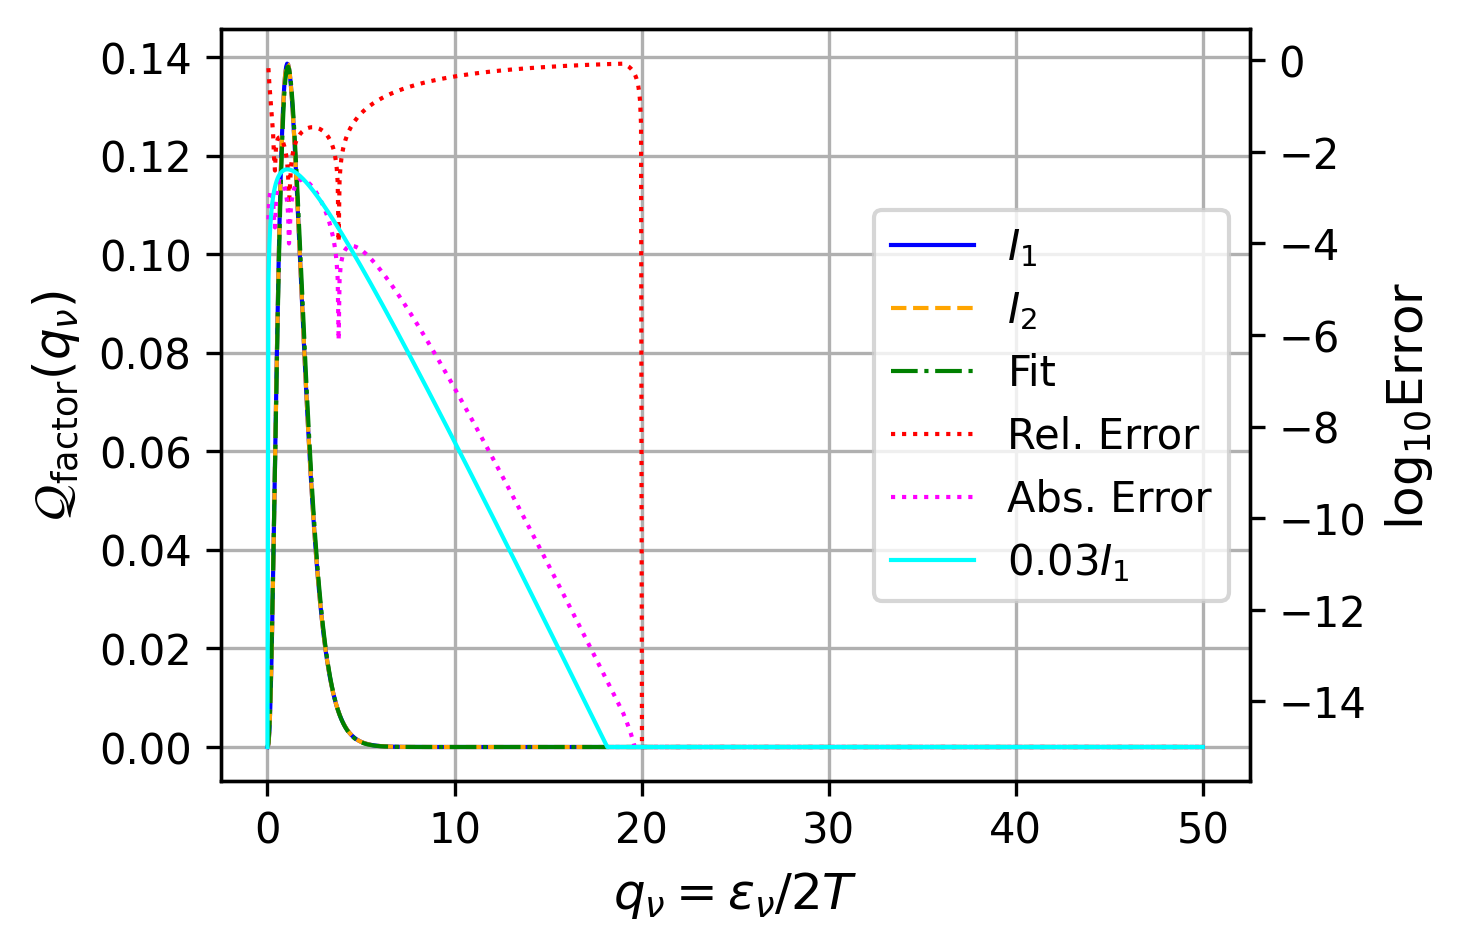

In [57]:
import numpy as np
import scipy.integrate as si
import matplotlib.pyplot as plt
from scipy.special import kn as Kn
from IPython.display import Image

def Q_single_integrand_1(q):
    return np.exp(-q)/q * Kn(1,q) * (q-qnu_local)**2

def Q_single_integrand_2(x):
    return np.exp(-2.0*qnu_local*x) * np.sqrt(x**2-x)/x**3

def fit(q):
    return 0.234 * (2.0*q)**2.4 * np.exp(-1.1*(2.0*q))

def rel_err(a,b):
    if a != 0.0:
        return np.abs(1.0-b/a)
    elif b != 0.0:
        return np.abs(1.0-a/b)
    else:
        return 0.0

N   = 1000
qnu = np.linspace(0,50,N)
I1  = np.zeros(N)
I2  = np.zeros(N)
for i in range(N):
    qnu_local = qnu[i]
    I1[i] = si.quad(Q_single_integrand_1,a=qnu_local,b=np.inf)[0]
    I2[i] = si.quad(Q_single_integrand_2,a=1,b=np.inf)[0]

fs = 12
lw = 1
fig, ax = plt.subplots(figsize=(3.54*1.25,3.54*3/4*1.25),dpi=300)
ax.set_xlabel(r"$q_{\nu}=\epsilon_{\nu}/2T$",fontsize=fs)
ax.set_ylabel(r"$\mathcal{Q}_{\rm factor}(q_{\nu})$",fontsize=fs)

I1_plot  = 2310/2048 * (2*qnu)**3 * I1
I2_plot  = 2310/2048 * (2*qnu)**3 * I2
fit_plot = fit(qnu)

leg1 = ax.plot(qnu,I1_plot, c='blue'  ,ls='-' ,label=r"$I_{1}$",lw=lw)
leg2 = ax.plot(qnu,I2_plot, c='orange',ls='--',label=r"$I_{2}$",lw=lw)
leg3 = ax.plot(qnu,fit_plot,c='green' ,ls="-.",label="Fit"     ,lw=lw)

fit_errors  = np.zeros(N)
abs_errors  = np.zeros(N)
claimed_err = np.zeros(N)
for i in range(N):
    I1_plot[i] = np.maximum(I1_plot[i],1e-15)
    I2_plot[i] = np.maximum(I2_plot[i],1e-15)
    fit_plot[i] = np.maximum(fit_plot[i],1e-15)
    err = rel_err(I1_plot[i],fit_plot[i])
    fit_errors[i]  = np.log10(np.maximum(err,1e-15))
    abs_errors[i]  = np.log10(np.maximum(np.abs(I1_plot[i]-fit_plot[i]),1e-15))
    claimed_err[i] = np.log10(np.maximum(0.03*I1_plot[i],1e-15))

ax_left = ax.twinx()
ax_left.set_ylabel(r"$\log_{10}\mathrm{Error}$",fontsize=fs)
leg4 = ax_left.plot(qnu[1:],fit_errors[1:],c='red' ,ls=":",label = "Rel. Error", lw=lw)
leg5 = ax_left.plot(qnu[1:],abs_errors[1:],c='magenta' ,ls=":",label = "Abs. Error", lw=lw)
leg6 = ax_left.plot(qnu,claimed_err,c='cyan',label=r"$0.03I_{1}$",lw=lw)

leg_all = leg1+leg2+leg3+leg4+leg5+leg6
leg_abs = [l.get_label() for l in leg_all]

ax.legend(leg_all,leg_abs,loc=5)
ax.grid()

outfig = "NNBrems_fit_vs_integral.png"
plt.savefig(outfig,dpi=300,bbox_inches='tight',facecolor='white')
plt.close(fig)
Image(outfig)

In [55]:
N   = 1000000
qnu = np.linspace(0,10000,N)
I   = np.zeros(N)
for i in range(N):
    qnu_local = qnu[i]
    I[i] = si.quad(Q_single_integrand_1,a=qnu_local,b=np.inf)[0]

I_int   = 2310/2048 * (2*qnu)**3 * I
fit_int = fit(qnu)

print("From fit : %.8lf"%(np.trapz(fit_int,x=qnu)*2))
print("From orig: %.8lf"%(np.trapz(I_int,x=qnu)*2))

From fit : 0.50451349
From orig: 0.50000000


0.5045134824555337

The neutrino number emission factor is obtained from

$$
\RR_{\rm factor}(\epsilon_{\nu}) = \frac{\QQ_{\rm factor}(\epsilon_{\nu})}{2q_{\nu}} = 0.234 \bigl(2q_{\nu}\bigr)^{1.4} e^{-1.1(2q_{\nu})}.
$$

We can now integrate these factors, obtaining

$$
\int_{0}^{\infty}d\epsilon_{\nu}\,\RR_{\rm factor}(\epsilon_{\nu})=0.234 \int_{0}^{\infy\bigl(2q_{\nu}\bigr)^{1.4} e^{-1.1(2q_{\nu})}
$$

In [6]:
def Q_integrand(x):
    return 0.234 * x**2.4 * np.exp(-1.1*x)

def R_integrand(x):
    return Q_integrand(x)/x

Q_factor = si.quad(Q_integrand,a=0,b=np.inf)[0]
R_factor = si.quad(R_integrand,a=0,b=np.inf)[0]
print("Q_factor = %.8lf\nR_factor = %.8lf"%(Q_factor,R_factor))

Q_factor = 0.50451348
R_factor = 0.23123535


In [7]:
# Step 2.a: Neutrino emission & cooling rates (electron capture)
def neutrino_emission_and_cooling_rates_Bremsstrahlung(rho_b,Ye,T,X_n,X_p):

    # Step 2.a.i: Compute common emission and cooling rates
    common_factor = Br_const * f_Br * (X_n**2 + X_p**2 + (28./3.)*X_n*X_p) * rhob**2 * T**(4.5)
    R_Br = 0.231 * common_factor
    Q_Br = 0.504 * common_factor * T

    # Step 2.a.ii: Compute rates of each neutrino species
    R_Br_nue  = R_Br
    R_Br_anue = R_Br
    R_Br_nux  = 4 * R_Br
    Q_Br_nue  = Q_Br
    Q_Br_anue = Q_Br
    Q_Br_nux  = 4 * Q_Br
    
    return R_Br_nue,Q_Br_nue, R_Br_anue,Q_Br_anue, R_Br_nux,Q_Br_nux